# Scaling peripheral fundus images using a reference point method - Part 1: Raytracing

This notebook illustrates the ray tracing simulations used in the paper *Patient-specific mapping of fundus photographs to three-dimensional ocular imaging* on an eye model based on clinical data.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zospy as zp

from helpers import get_nodal_points, get_retina_locations, InputOutputAngles

## Initialize OpticStudio

Establishing a connection with OpticStudio through the [ZOSPy](https://joss.theoj.org/papers/10.21105/joss.05756) library. 

In  this example we connect with OpticStudio in `extension` mode. For more extensive simulations we advise to use the `standalone` for a significant increase in computation performace.

In [2]:
zos = zp.ZOS()
zos.wakeup()

In [3]:
zos.connect_as_extension()
oss = zos.get_primary_system()

## Define the eye model

The used eye model is based upon clinical measurements of healthy subject.

In [4]:
# navarro_geometry = {
#     "axial_length": 23.9203,  # mm
#     "cornea_thickness": 0.5,  # mm
#     "anterior_chamber_depth": 3.05,  # mm
#     "lens_thickness": 4.0,  # mm
#     "cornea_front_curvature": 7.72,  # mm
#     "cornea_front_asphericity": -0.26,
#     "cornea_back_curvature": 6.5,  # mm
#     "cornea_back_asphericity": 0,
#     "iris_radius": 0.5,  # mm
#     "lens_front_curvature": 10.2,  # mm
#     "lens_front_asphericity": -3.1316,
#     "lens_back_curvature": -6.0,  # mm
#     "lens_back_asphericity": -1,
#     "retina_curvature": -12.0,  # mm
#     "retina_asphericity": 0.0,
# }

geometry = {
    "axial_length": 24.305,  # mm
    "cornea_thickness": 0.5615,  # mm
    "anterior_chamber_depth": 3.345,  # mm
    "lens_thickness": 3.17,  # mm
    "cornea_front_curvature": 7.6967,  # mm
    "cornea_front_asphericity": -0.2304,
    "cornea_back_curvature": 6.2343,  # mm
    "cornea_back_asphericity": -0.1444,
    "iris_radius": 0.5,  # mm
    "lens_front_curvature": 10.2,  # mm
    "lens_front_asphericity": -3.1316,
    "lens_back_curvature": -5.4537,  # mm
    "lens_back_asphericity": -4.1655,
    "retina_curvature": -11.3357,  # mm
    "retina_asphericity": -0.0631,
}

geometry["vitreous_thickness"] = geometry["axial_length"] - (
    geometry["cornea_thickness"]
    + geometry["anterior_chamber_depth"]
    + geometry["lens_thickness"]
)
geometry["retina_radius_z"] = abs(
    geometry["retina_curvature"] / (geometry["retina_asphericity"] + 1)
)
geometry["retina_radius_y"] = abs(
    geometry["retina_curvature"] / np.sqrt(geometry["retina_asphericity"] + 1)
)

# For the Lamberth projection, a spherical retina needs to be used
# mean_retina_radius = np.mean([geometry["retina_radius_z"], geometry["retina_radius_y"]])
# geometry["retina_curvature"] = geometry["retina_radius_y"] = geometry[
#     "retina_radius_z"
# ] = -mean_retina_radius
# geometry["retina_asphericity"] = 0.0

refractive_indices = {  # at 543 nm (green light)
    "cornea": 1.3777,
    "aqueous": 1.3391,
    "lens": 1.4222,
    "vitreous": 1.3377,
}

with open("data/geometry.json", "w") as f:
    json.dump(geometry, f)

### Initialize the optical system in OpticStudio

For ray tracing, a wavelength of 543 nm (in the center of the visible spectrum) is used,
with input beams angles from 0° to 85° in steps of 5°.

Ray aiming (a feature of OpticStudio which shifts peripheral input beams so they pass through the center of the actual pupil) is turned off, as in ophthalmic imaging the entrance pupil is in the center of the image.

In [5]:
APERTURE = zp.constants.SystemData.ZemaxApertureType.FloatByStopSize
WAVELENGTH = 0.543  # nm
FIELDS = np.arange(0, 90, 5)  # degrees with respect to the optical axis

In [6]:
oss.new()

oss.SystemData.Aperture.ApertureType = (
    zp.constants.SystemData.ZemaxApertureType.FloatByStopSize
)
oss.SystemData.Wavelengths.GetWavelength(1).Wavelength = WAVELENGTH
oss.SystemData.RayAiming.RayAiming = zp.constants.SystemData.RayAimingMethod.Off

# Add fields
for i, f in enumerate(np.array(FIELDS).astype(float)):
    if i == 0:
        oss.SystemData.Fields.GetField(1).X = 0
        oss.SystemData.Fields.GetField(1).Y = f
        oss.SystemData.Fields.GetField(1).Weight = 1
    else:
        oss.SystemData.Fields.AddField(X=0, Y=f, Weight=1)

### Create the eye model

For each of the surfaces the curvature, asphericity, thickness and refractive index is set.

In [7]:
# Dummy surface, needed for calculation of input angles
input_beam = oss.LDE.InsertNewSurfaceAt(1)
input_beam.Comment = "Input beam"
input_beam.Thickness = 1.0
input_beam.DrawData.DoNotDrawThisSurface = True

cornea_front = oss.LDE.InsertNewSurfaceAt(2)
cornea_front.Comment = "Cornea Front"
cornea_front.Thickness = geometry["cornea_thickness"]
cornea_front.Radius = geometry["cornea_front_curvature"]
cornea_front.Conic = geometry["cornea_front_asphericity"]
zp.solvers.material_model(
    cornea_front.MaterialCell, refractive_index=refractive_indices["cornea"]
)

cornea_back = oss.LDE.InsertNewSurfaceAt(3)
cornea_back.Comment = "Cornea Back / Aqueous"
cornea_back.Thickness = geometry["anterior_chamber_depth"]
cornea_back.Radius = geometry["cornea_back_curvature"]
cornea_back.Conic = geometry["cornea_back_asphericity"]
zp.solvers.material_model(
    cornea_back.MaterialCell, refractive_index=refractive_indices["aqueous"]
)
cornea_back.DrawData.DoNotDrawEdgesFromThisSurface = True

pupil = oss.LDE.GetSurfaceAt(4)
assert pupil.IsStop, "Pupil must be the STOP surface."
pupil.Comment = "Pupil"
pupil.SemiDiameter = geometry["iris_radius"]
zp.solvers.material_model(
    pupil.MaterialCell, refractive_index=refractive_indices["aqueous"]
)
pupil.DrawData.DoNotDrawEdgesFromThisSurface = True

lens_front = oss.LDE.InsertNewSurfaceAt(5)
lens_front.Comment = "Lens Front"
lens_front.Thickness = geometry["lens_thickness"]
lens_front.Radius = geometry["lens_front_curvature"]
lens_front.Conic = geometry["lens_front_asphericity"]
lens_front.SemiDiameter = 4.0  # Larger diameter for visualization purposes
zp.solvers.material_model(
    lens_front.MaterialCell, refractive_index=refractive_indices["lens"]
)

lens_back = oss.LDE.InsertNewSurfaceAt(6)
lens_back.Comment = "Lens Back / Vitreous"
lens_back.Thickness = geometry["vitreous_thickness"]
lens_back.Radius = geometry["lens_back_curvature"]
lens_back.Conic = geometry["lens_back_asphericity"]
zp.solvers.material_model(
    lens_back.MaterialCell, refractive_index=refractive_indices["vitreous"]
)
lens_back.DrawData.DoNotDrawEdgesFromThisSurface = True

retina = oss.LDE.GetSurfaceAt(7)
assert retina.IsImage, "Retina must be the IMAGE surface."
retina.Comment = "Retina"
retina.Radius = geometry["retina_curvature"]
retina.Conic = geometry["retina_asphericity"]
retina.Thickness = 0
# Set the refractive index of the retina to the vitreous to prevent reflections
zp.solvers.material_model(
    retina.MaterialCell, refractive_index=refractive_indices["vitreous"]
)

# Modify the settings for the visualization of the system
for i in range(1, oss.LDE.NumberOfSurfaces + 1):
    oss.LDE.GetSurfaceAt(
        i
    ).DrawData.DrawEdgesAs = zp.constants.Editors.LDE.SurfaceEdgeDraw.Flat

Display the eye model in OpticStudio.

In [8]:
zp.analyses.systemviewers.viewer_3d(oss)

'AnalysisType': 'Draw3D'
'Data': None
'HeaderData': []
'Messages': []
'MetaData': AnalysisMetadata(DateTime=datetime.datetime(2024, 7, 25, 9, 47, 15, 937000), FeatureDescription='', LensFile='D:\\Zemax\\SAMPLES\\LENS.zmx', LensTitle='')
'Settings': None

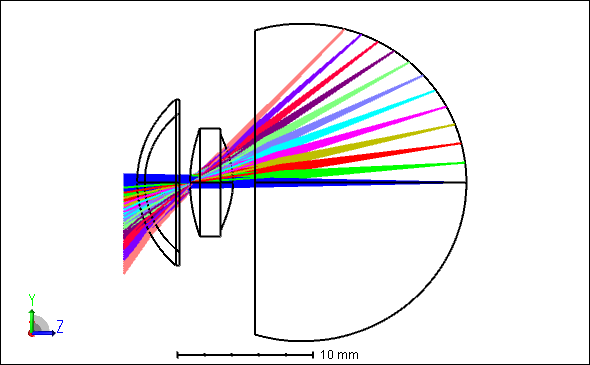

## Perform ray tracing

Rays are traced from the light source (the camera) to retina, for the different fields that have been configured in OpticStudio.

The results are evaluated in terms of camera angles and retinal angles. For the latter three reference points are compared:
the second nodal point, the retinal center and the pupil.

In [9]:
ray_trace_results = {}
input_output_angles = []

# Nodal points are calculated in OpticStudio, but can also be calculated analytically
np1, np2 = get_nodal_points(oss)

for i in range(1, oss.SystemData.Fields.NumberOfFields + 1):
    y_angle = oss.SystemData.Fields.GetField(i).Y
    ray_trace_results[y_angle] = zp.analyses.raysandspots.single_ray_trace(
        oss, px=0, py=0, field=i, global_coordinates=True
    )
    ray_trace_results[y_angle].Data.RealRayTraceData["InputAngle"] = y_angle

    input_output_angles.append(
        InputOutputAngles.from_ray_trace_result(
            ray_trace_results[y_angle],
            y_angle,
            np2=np2,
            np2_navarro=np2,
            retina_center=(
                geometry["lens_thickness"]
                + geometry["vitreous_thickness"]
                - (
                    abs(
                        geometry["retina_curvature"]
                        / (geometry["retina_asphericity"] + 1)
                    )
                )
            ),
            patient="Patient1",
        )
    )

real_ray_trace_results = pd.concat(
    r.Data.RealRayTraceData for r in ray_trace_results.values()
)
input_output_angles = pd.DataFrame(input_output_angles)

Add the retinal locations to the dataframe

In [10]:
input_output_angles["retina_location"] = input_output_angles.apply(
    lambda r: get_retina_locations(r, real_ray_trace_results), axis=1
)

input_output_angles

,input_angle_field,input_angle_cornea,input_angle_pupil,output_angle_pupil,output_angle_np2,output_angle_retina_center,output_angle_navarro_np2,location_np2,location_retina_center,patient,retina_location
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.457872,8.299343,Patient1,"(20.3985, 0.0)"
1,10.0,10.0,8.559338,8.236620,9.924741,13.887107,9.924741,3.457872,8.299343,Patient1,"(20.022129705, 2.8982969683)"
2,20.0,20.0,17.125957,16.461583,19.876188,27.752562,19.876188,3.457872,8.299343,Patient1,"(18.929358005, 5.5933282836)"
3,30.0,30.0,25.710515,24.653892,29.866615,41.532014,29.866615,3.457872,8.299343,Patient1,"(17.225415858, 7.9060177623)"
4,40.0,40.0,34.330320,32.778578,39.883907,55.092636,39.883907,3.457872,8.299343,Patient1,"(15.071429925, 9.7049004243)"
5,50.0,50.0,43.012066,40.784670,49.883060,68.229900,49.883060,3.457872,8.299343,Patient1,"(12.661808084, 10.923468966)"
6,60.0,60.0,51.792984,48.602608,59.775819,80.686513,59.775819,3.457872,8.299343,Patient1,"(10.196207912, 11.566389056)"
7,70.0,70.0,60.718906,56.149161,69.430824,92.200759,69.430824,3.457872,8.299343,Patient1,"(7.8495996064, 11.703115207)"
8,80.0,80.0,69.838344,63.373162,78.731841,102.612037,78.731841,3.457872,8.299343,Patient1,"(5.7383659648, 11.445857555)"
9,5.0,5.0,4.279254,4.118911,4.960514,6.944355,4.960514,3.457872,8.299343,Patient1,"(20.303833183, 1.4621330149)"


Save the output

In [11]:
real_ray_trace_results.to_csv("data/ray_trace_results.csv", index=False)
input_output_angles.to_csv("data/input_output_angles.csv", index=False)

Plot the relations between input angles (camera angles) and output angles (retinal angles)

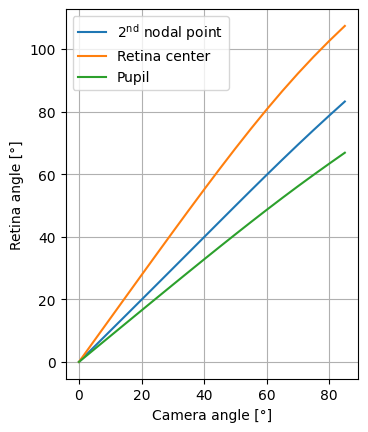

In [12]:
fig, ax = plt.subplots()

sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_np2",
    label="$2^{\\mathrm{nd}}$ nodal point",
)
sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_retina_center",
    label="Retina center",
)
sns.lineplot(
    data=input_output_angles,
    x="input_angle_field",
    y="output_angle_pupil",
    label="Pupil",
)

ax.set_xlabel("Camera angle [°]")
ax.set_ylabel("Retina angle [°]")
ax.set_aspect("equal")
ax.grid()